In [1]:
!pip install pynrrd

**LOAD DATA**

In [2]:
import nrrd
import os

def load_nrrd_files(data_path):
    images = {}
    for file in os.listdir(data_path):
        if file.endswith('.nrrd'):
            image, header = nrrd.read(os.path.join(data_path, file))
            images[file] = image
    return images

data_path = "/kaggle/input/train-data/Train"
ct_images = load_nrrd_files(data_path)


In [3]:
import pandas as pd

labels = pd.read_excel("/kaggle/input/dataset-lung/dataset_lung.xlsx")
print(labels.head())


            Full_slice            Nodule  TumorClass
0  pat1_fullslice.nrrd  pat1_nodule.nrrd           5
1  pat2_fullslice.nrrd  pat2_nodule.nrrd           5
2  pat3_fullslice.nrrd  pat3_nodule.nrrd           2
3  pat4_fullslice.nrrd  pat4_nodule.nrrd           5
4  pat5_fullslice.nrrd  pat5_nodule.nrrd           4


In [4]:
def match_images_with_labels(images, labels):
    data = []
    for index, row in labels.iterrows():
        full_slice_file = row['Full_slice']  # File name for full slice
        nodule_file = row['Nodule']          # File name for nodule
        malignancy = row['TumorClass']       # Malignancy score (1-5)

        # Extract patient ID from the file name (assuming it starts with 'patX')
        patient_id = full_slice_file.split('_')[0]  # Extracts 'pat1' from 'pat1_fullslice.nrrd'

        # Check if the images exist in the dictionary
        if full_slice_file in images and nodule_file in images:
            data.append({
                "patient_id": patient_id,               # Add patient_id
                "full_slice": images[full_slice_file],
                "nodule": images[nodule_file],
                "malignancy": malignancy
            })

    return pd.DataFrame(data)

# Example usage
prepared_data = match_images_with_labels(ct_images, labels)
print(prepared_data.head())


  patient_id                                         full_slice  \
0       pat1  [[-2048, -2048, -2048, -2048, -2048, -2048, -2...   
1       pat2  [[-3024, -3024, -3024, -3024, -3024, -3024, -3...   
2       pat3  [[-2048, -2048, -2048, -2048, -2048, -2048, -2...   
3       pat4  [[-2048, -2048, -2048, -2048, -2048, -2048, -2...   
4       pat5  [[-2048, -2048, -2048, -2048, -2048, -2048, -2...   

                                              nodule  malignancy  
0  [[470, 445, 432, 296, 103, 35, -95, -237, -470...           5  
1  [[-923, -913, -886, -878, -828, -711, -626, -6...           5  
2  [[493, 521, 422, 53, -500, -818, -878, -879, -...           2  
3  [[-855, -848, -877, -884, -868, -875, -847, -8...           5  
4  [[81, 71, 74, 61, 63, 60, 61, 71, 53, 35, 19, ...           4  


**Utility functions**

In [5]:
import cv2
import numpy as np

def resize_images(image, size=(256, 256)):
    # Ensure resizing and single channel
    from skimage.transform import resize
    image = resize(image, size, anti_aliasing=True)
    if len(image.shape) == 3:  # If multiple channels exist
        image = image[:, :, 0]  # Keep only one channel
    return image




In [6]:
def normalize_image(image):
    # Normalize the image to [0, 1] and convert to float32
    image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)
    return image.astype(np.float32)


**Data analysis**

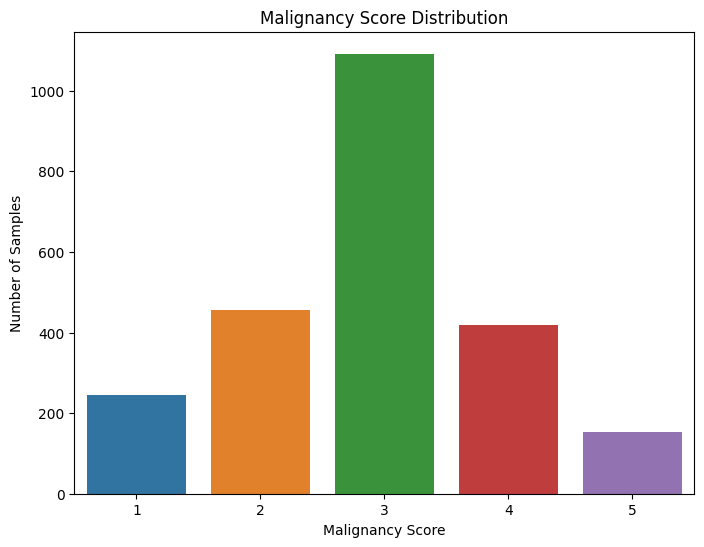

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count occurrences of each label
label_counts = prepared_data['malignancy'].value_counts().sort_index()

# Plot distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Malignancy Score Distribution")
plt.xlabel("Malignancy Score")
plt.ylabel("Number of Samples")
plt.show()


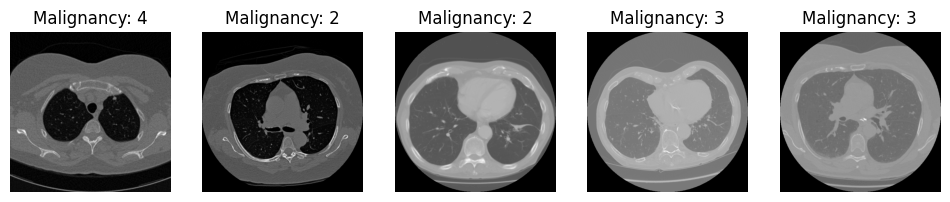

In [8]:
import random

def visualize_samples(data, num_samples=5):
    samples = random.sample(range(len(data)), num_samples)
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(samples):
        full_slice = data.iloc[idx]['full_slice']
        plt.subplot(1, num_samples, i+1)
        plt.imshow(full_slice, cmap='gray')
        plt.title(f"Malignancy: {data.iloc[idx]['malignancy']}")
        plt.axis('off')
    plt.show()

visualize_samples(prepared_data)


In [9]:
import numpy as np

def check_image_statistics(data):
    stats = []
    for _, row in data.iterrows():
        full_slice = row['full_slice']
        nodule = row['nodule']

        stats.append({
            "patient_id": row['patient_id'],
            "full_slice_mean": np.mean(full_slice),
            "full_slice_std": np.std(full_slice),
            "nodule_mean": np.mean(nodule),
            "nodule_std": np.std(nodule)
        })

    return pd.DataFrame(stats)

image_stats = check_image_statistics(prepared_data)
print(image_stats.describe())


       full_slice_mean  full_slice_std  nodule_mean   nodule_std
count      2363.000000     2363.000000  2363.000000  2363.000000
mean       -783.503576      798.971343  -591.191521   352.070691
std         207.809384      272.539335   185.029675   130.470924
min       -1198.236568      338.895320  -951.700335    37.942447
25%        -959.790331      488.599956  -759.698388   253.492560
50%        -815.057644      775.485301  -580.165799   386.478686
75%        -588.812559     1116.280931  -443.690875   450.194868
max        -189.996593     1231.754362     5.439867   958.926382


In [10]:
Q1 = image_stats['full_slice_mean'].quantile(0.25)
Q3 = image_stats['full_slice_mean'].quantile(0.75)
IQR = Q3 - Q1

outliers = image_stats[(image_stats['full_slice_mean'] < (Q1 - 1.5 * IQR)) | 
                       (image_stats['full_slice_mean'] > (Q3 + 1.5 * IQR))]
print(f"Number of outliers detected: {len(outliers)}")


Number of outliers detected: 0


In [11]:
cleaned_data = prepared_data[~prepared_data['patient_id'].isin(outliers['patient_id'])]


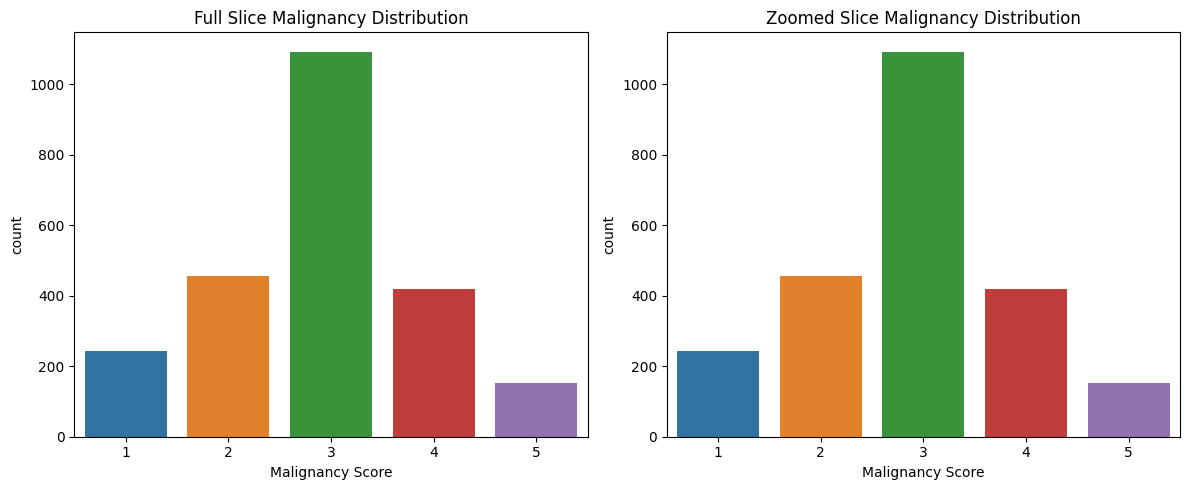

In [12]:
# Example: Comparing full slice and nodule distribution
full_slices_labels = prepared_data[['full_slice', 'malignancy']].copy()
zoomed_slices_labels = prepared_data[['nodule', 'malignancy']].copy()

# Visualize distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=full_slices_labels['malignancy'])
plt.title("Full Slice Malignancy Distribution")
plt.xlabel("Malignancy Score")

plt.subplot(1, 2, 2)
sns.countplot(x=zoomed_slices_labels['malignancy'])
plt.title("Zoomed Slice Malignancy Distribution")
plt.xlabel("Malignancy Score")

plt.tight_layout()
plt.show()


**Prepare data**

In [13]:
import torchvision.transforms as transforms
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Define augmentations for full_slice and nodule images
augmentations = transforms.Compose([
    transforms.ToPILImage(),                    # Convert array to PIL image
    transforms.RandomHorizontalFlip(p=0.5),     # Horizontal flip
    transforms.RandomRotation(degrees=10),      # Random rotation between -10° to 10°
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Shift images up to 10%
    transforms.ColorJitter(brightness=0.1, contrast=0.1),      # Adjust brightness and contrast
    transforms.ToTensor()                       # Convert back to tensor
])
class LungCancerDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        full_slice = self.data.iloc[idx]['full_slice']
        nodule = self.data.iloc[idx]['nodule']
        label = self.data.iloc[idx]['malignancy'] - 1  # Shift to range [0-4]

        # Resize and normalize
        full_slice = resize_images(full_slice).astype(np.float32)
        nodule = resize_images(nodule).astype(np.float32)

        # Ensure single-channel
        if len(full_slice.shape) == 3:  # (H, W, C)
            full_slice = full_slice[:, :, 0]  # Keep only the first channel
        if len(nodule.shape) == 3:  # (H, W, C)
            nodule = nodule[:, :, 0]

        # Convert to tensors
        full_slice = torch.tensor(full_slice, dtype=torch.float32).unsqueeze(0)  # Add channel dim
        nodule = torch.tensor(nodule, dtype=torch.float32).unsqueeze(0)

        if self.transform:
            full_slice = self.transform(full_slice)
            nodule = self.transform(nodule)

        return {
            "full_slice": full_slice,
            "nodule": nodule,
            "label": torch.tensor(label, dtype=torch.long)
        }


In [14]:
#FOR BINARY CASE
class LungCancerBinaryDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        full_slice = self.data.iloc[idx]['full_slice']
        nodule = self.data.iloc[idx]['nodule']
        label = self.data.iloc[idx]['binary_label']  # Binary label (0 or 1)

        # Preprocessing
        full_slice = resize_images(full_slice)
        nodule = resize_images(nodule)
        full_slice = normalize_image(full_slice)
        nodule = normalize_image(nodule)

        # Ensure single-channel
        if len(full_slice.shape) == 3:  # (H, W, C)
            full_slice = full_slice[:, :, 0]
        if len(nodule.shape) == 3:  # (H, W, C)
            nodule = nodule[:, :, 0]

        # Convert to tensors
        full_slice = torch.tensor(full_slice, dtype=torch.float32).unsqueeze(0)  # Add channel dim
        nodule = torch.tensor(nodule, dtype=torch.float32).unsqueeze(0)

        if self.transform:
            full_slice = self.transform(full_slice)
            nodule = self.transform(nodule)

        # Verify shapes
        #print(f"full_slice shape: {full_slice.shape}, nodule shape: {nodule.shape}")
            

        return {
            "full_slice": full_slice,
            "nodule": nodule,
            "label": torch.tensor(label, dtype=torch.long)
        }

In [15]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming prepared_data is the complete dataset
print("Original dataset size:", len(prepared_data))

# Split into train (70%) and temp (30%) while stratifying on 'malignancy'
train_data, temp_data = train_test_split(
    prepared_data, 
    test_size=0.3, 
    stratify=prepared_data['malignancy'], 
    random_state=42
)

# Split temp into validation (15%) and test (15%)
val_data, test_data = train_test_split(
    temp_data, 
    test_size=0.5, 
    stratify=temp_data['malignancy'], 
    random_state=42
)

print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Test size: {len(test_data)}")


Original dataset size: 2363
Train size: 1654
Validation size: 354
Test size: 355


In [16]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Define augmentations for training set (optional for validation and test)
augmentations = transforms.Compose([
    transforms.ToPILImage(),                    # Convert array to PIL image
    transforms.Grayscale(num_output_channels=1), # Ensure grayscale with 1 channel
    transforms.RandomHorizontalFlip(p=0.5),     # Horizontal flip
    transforms.RandomRotation(degrees=10),      # Random rotation between -10° to 10°
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Shift images up to 10%
    transforms.ColorJitter(brightness=0.1, contrast=0.1),      # Adjust brightness and contrast
    transforms.ToTensor()                       # Convert back to tensor
])


# For MULTI-CLASS CASE
# Create PyTorch datasets
train_dataset_multi = LungCancerDataset(train_data, transform=augmentations)
val_dataset_multi = LungCancerDataset(val_data, transform=None)  # No augmentation for validation
test_dataset_multi = LungCancerDataset(test_data, transform=None)  # No augmentation for test

# Create DataLoaders
train_loader_multi = DataLoader(train_dataset_multi, batch_size=8, shuffle=True)
val_loader_multi = DataLoader(val_dataset_multi, batch_size=8, shuffle=False)
test_loader_multi = DataLoader(test_dataset_multi, batch_size=8, shuffle=False)

print("Multi-class DataLoaders:")
print(f"Train batches: {len(train_loader_multi)}")
print(f"Validation batches: {len(val_loader_multi)}")
print(f"Test batches: {len(test_loader_multi)}")

# FOR BINARY CASE
# Relabel data for binary classification
train_data_binary = train_data.copy()
train_data_binary['binary_label'] = train_data_binary['malignancy'].apply(lambda x: 0 if x <= 3 else 1)
val_data_binary = val_data.copy()
val_data_binary['binary_label'] = val_data_binary['malignancy'].apply(lambda x: 0 if x <= 3 else 1)
test_data_binary = test_data.copy()
test_data_binary['binary_label'] = test_data_binary['malignancy'].apply(lambda x: 0 if x <= 3 else 1)

# Create PyTorch datasets for binary classification
train_dataset_binary = LungCancerBinaryDataset(train_data_binary, transform=augmentations)
val_dataset_binary = LungCancerBinaryDataset(val_data_binary, transform=None)
test_dataset_binary = LungCancerBinaryDataset(test_data_binary, transform=None)

# Create DataLoaders
train_loader_binary = DataLoader(train_dataset_binary, batch_size=8, shuffle=True)
val_loader_binary = DataLoader(val_dataset_binary, batch_size=8, shuffle=False)
test_loader_binary = DataLoader(test_dataset_binary, batch_size=8, shuffle=False)

print("\nBinary Classification DataLoaders:")
print(f"Train batches: {len(train_loader_binary)}")
print(f"Validation batches: {len(val_loader_binary)}")
print(f"Test batches: {len(test_loader_binary)}")


Multi-class DataLoaders:
Train batches: 207
Validation batches: 45
Test batches: 45

Binary Classification DataLoaders:
Train batches: 207
Validation batches: 45
Test batches: 45


In [17]:
#to check gray scale conversion
dataset = LungCancerDataset(train_data, transform=augmentations)
sample = dataset[0]


**Balancing the dataset**

In [18]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
from sklearn.utils import class_weight
import torch

# Compute class weights for multi-class classification
train_labels_multi = train_data['malignancy']

# Calculate class weights
class_weights_multi = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_multi),
    y=train_labels_multi
)

# Convert to PyTorch tensor
class_weights_multi_tensor = torch.tensor(class_weights_multi, dtype=torch.float32).to(device)

# Print class weights for each class
print("Class Weights for Multi-class Classification:")
for cls, weight in zip(np.unique(train_labels_multi), class_weights_multi):
    print(f"Class {cls}: Weight {weight:.4f}")


Class Weights for Multi-class Classification:
Class 1: Weight 1.9345
Class 2: Weight 1.0337
Class 3: Weight 0.4330
Class 4: Weight 1.1290
Class 5: Weight 3.1208


In [20]:
# Compute class weights for binary classification
train_labels_binary = train_data_binary['binary_label']

# Calculate class weights
class_weights_binary = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_binary),
    y=train_labels_binary
)

# Convert to PyTorch tensor
class_weights_binary_tensor = torch.tensor(class_weights_binary, dtype=torch.float32).to(device)

# Print class weights for binary classification
print("\nClass Weights for Binary Classification:")
for cls, weight in zip(np.unique(train_labels_binary), class_weights_binary):
    print(f"Class {cls}: Weight {weight:.4f}")



Class Weights for Binary Classification:
Class 0: Weight 0.6590
Class 1: Weight 2.0727


**Training model**

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import numpy as np
import pandas as pd


class LungCancerDualInputCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(LungCancerDualInputCNN, self).__init__()

        # Convolutional layers for full_slice
        self.conv1_full = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2_full = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((8, 8))  # Fixed size output feature map

        # Convolutional layers for nodule
        self.conv1_nodule = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2_nodule = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8 * 2, 256)  # Adjusted input size
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, full_slice, nodule):
        # Forward pass for full_slice
        x1 = self.pool(F.relu(self.conv1_full(full_slice)))
        x1 = self.pool(F.relu(self.conv2_full(x1)))
        x1 = x1.view(x1.size(0), -1)  # Flatten

        # Forward pass for nodule
        x2 = self.pool(F.relu(self.conv1_nodule(nodule)))
        x2 = self.pool(F.relu(self.conv2_nodule(x2)))
        x2 = x2.view(x2.size(0), -1)  # Flatten

        # Concatenate the two feature maps
        x = torch.cat((x1, x2), dim=1)

        # Fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x



In [22]:
def get_confidence_scores(outputs):
    probabilities = F.softmax(outputs, dim=1)  # Convert logits to probabilities
    confidence, predictions = torch.max(probabilities, 1)
    return confidence, predictions


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils import class_weight



def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, task="Binary"):
    """
    Training function for the model with two inputs (full_slice and nodule).

    Parameters:
        model: The PyTorch model to train.
        criterion: Loss function with class weights integrated.
        optimizer: Optimizer for updating weights.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        num_epochs: Number of epochs to train.
        task: "Binary" or "Multi-class" for logging.
    """
    model.to(device)
    for epoch in range(num_epochs):
        # Initialize tracking variables

        torch.cuda.empty_cache()

        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training phase
        for batch in train_loader:
            full_slice = batch['full_slice'].to(device)
            nodule = batch['nodule'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(full_slice, nodule)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_acc = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for batch in val_loader:
                full_slice = batch['full_slice'].to(device)
                nodule = batch['nodule'].to(device)
                labels = batch['label'].to(device)

                # Debugging: Check labels
                #print(f"Labels Shape: {labels.shape}, Unique Labels: {labels.unique()}")

                outputs = model(full_slice, nodule)
                #print(f"Outputs Shape: {outputs.shape}")  # Check model output
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_acc = 100 * correct_val / total_val

        # Print statistics for the epoch
        print(f"[{task}] Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_acc:.2f}%")


In [24]:
print("Unique Labels in Training Set:", train_data['malignancy'].unique())
print("Unique Labels in Validation Set:", val_data['malignancy'].unique())


Unique Labels in Training Set: [4 2 3 5 1]
Unique Labels in Validation Set: [3 1 4 2 5]


In [25]:
for batch in train_loader_multi:
    full_slice = batch['full_slice']
    nodule = batch['nodule']
    print("Full Slice dtype:", full_slice.dtype)
    print("Nodule dtype:", nodule.dtype)
    break


Full Slice dtype: torch.float32
Nodule dtype: torch.float32


In [26]:
torch.cuda.empty_cache()


In [27]:
# Define model, loss function, and optimizer
multi_model_dual = LungCancerDualInputCNN(num_classes=5).to(device)
multi_criterion = nn.CrossEntropyLoss(weight=class_weights_multi_tensor)
multi_optimizer = optim.Adam(multi_model_dual.parameters(), lr=0.001)

# Train the multi-class model
print("\nTraining Multi-class Classification Model with Full_slice and Nodule...")
train_model(multi_model_dual, multi_criterion, multi_optimizer, train_loader_multi, val_loader_multi, num_epochs=10, task="Multi-class")



Training Multi-class Classification Model with Full_slice and Nodule...
[Multi-class] Epoch [1/10]
  Train Loss: 1.6101, Train Accuracy: 34.28%
  Val Loss: 1.6044, Val Accuracy: 46.33%
[Multi-class] Epoch [2/10]
  Train Loss: 1.5930, Train Accuracy: 36.22%
  Val Loss: 1.8201, Val Accuracy: 19.21%
[Multi-class] Epoch [3/10]
  Train Loss: 1.5370, Train Accuracy: 33.31%
  Val Loss: 1.9641, Val Accuracy: 19.21%
[Multi-class] Epoch [4/10]
  Train Loss: 1.4978, Train Accuracy: 33.98%
  Val Loss: 1.9944, Val Accuracy: 19.21%
[Multi-class] Epoch [5/10]
  Train Loss: 1.4518, Train Accuracy: 36.28%
  Val Loss: 2.3316, Val Accuracy: 19.21%
[Multi-class] Epoch [6/10]
  Train Loss: 1.4479, Train Accuracy: 36.46%
  Val Loss: 2.7140, Val Accuracy: 19.21%
[Multi-class] Epoch [7/10]
  Train Loss: 1.4405, Train Accuracy: 38.45%
  Val Loss: 2.5747, Val Accuracy: 19.21%
[Multi-class] Epoch [8/10]
  Train Loss: 1.4366, Train Accuracy: 36.76%
  Val Loss: 2.5446, Val Accuracy: 19.21%
[Multi-class] Epoch [9/

In [28]:
for batch in train_loader_multi:
    full_slice = batch['full_slice'].to(device)
    nodule = batch['nodule'].to(device)
    labels = batch['label'].to(device)

    print("Batch Full Slice Shape:", full_slice.shape)  # Should be [Batch, 1, 256, 256]
    print("Batch Nodule Shape:", nodule.shape)          # Should be [Batch, 1, 256, 256]

    # Run through the model
    outputs = multi_model_dual(full_slice, nodule)
    print("Model Output Shape:", outputs.shape)  # Should be [Batch, num_classes]
    break


Batch Full Slice Shape: torch.Size([8, 1, 256, 256])
Batch Nodule Shape: torch.Size([8, 1, 256, 256])
Model Output Shape: torch.Size([8, 5])


In [29]:
# Define model, loss function, and optimizer
binary_model_dual = LungCancerDualInputCNN(num_classes=2).to(device)
binary_criterion = nn.CrossEntropyLoss(weight=class_weights_binary_tensor)
binary_optimizer = optim.Adam(binary_model_dual.parameters(), lr=0.001)

# Train the binary model
print("\nTraining Binary Classification Model with Full_slice and Nodule...")
train_model(binary_model_dual, binary_criterion, binary_optimizer, train_loader_binary, val_loader_binary, num_epochs=10, task="Binary")



Training Binary Classification Model with Full_slice and Nodule...
[Binary] Epoch [1/10]
  Train Loss: 0.6744, Train Accuracy: 71.83%
  Val Loss: 0.6657, Val Accuracy: 74.29%
[Binary] Epoch [2/10]
  Train Loss: 0.6469, Train Accuracy: 68.32%
  Val Loss: 0.6671, Val Accuracy: 74.86%
[Binary] Epoch [3/10]
  Train Loss: 0.6173, Train Accuracy: 72.67%
  Val Loss: 0.6206, Val Accuracy: 70.62%
[Binary] Epoch [4/10]
  Train Loss: 0.6172, Train Accuracy: 71.16%
  Val Loss: 0.6921, Val Accuracy: 74.58%
[Binary] Epoch [5/10]
  Train Loss: 0.6072, Train Accuracy: 73.04%
  Val Loss: 0.6082, Val Accuracy: 74.29%
[Binary] Epoch [6/10]
  Train Loss: 0.6023, Train Accuracy: 75.21%
  Val Loss: 0.6025, Val Accuracy: 72.60%
[Binary] Epoch [7/10]
  Train Loss: 0.5969, Train Accuracy: 74.85%
  Val Loss: 0.6118, Val Accuracy: 72.60%
[Binary] Epoch [8/10]
  Train Loss: 0.5902, Train Accuracy: 75.63%
  Val Loss: 0.6401, Val Accuracy: 62.43%
[Binary] Epoch [9/10]
  Train Loss: 0.5911, Train Accuracy: 74.18%
 

In [35]:
def evaluate_model(model, data_loader, task="Binary"):
    """
    Evaluate the trained model on a test set and compute accuracy and confidence scores.

    Parameters:
        model: The trained PyTorch model.
        data_loader: DataLoader for test data.
        task: "Binary" or "Multi-class" for logging.

    Returns:
        Average accuracy, confidence, and confidence-weighted evaluation score.
    """
    model.eval()
    correct = 0
    total = 0
    total_confidence = 0.0
    evaluation_score = 0.0

    all_confidences = []
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:  # Access batches as dictionaries
            full_slice = batch['full_slice'].to(device)  # Use full_slice
            nodule = batch['nodule'].to(device)          # Use nodule
            labels = batch['label'].to(device)

            # Forward pass with both inputs
            outputs = model(full_slice, nodule)
            confidence, predictions = get_confidence_scores(outputs)

            # Track metrics
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            total_confidence += confidence.sum().item()

            # Confidence-weighted evaluation score
            evaluation_score += (confidence * (predictions == labels).float()).sum().item()

            # Collect results
            all_confidences.extend(confidence.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate overall metrics
    accuracy = 100 * correct / total
    average_confidence = total_confidence / total
    confidence_weighted_score = evaluation_score / total

    print(f"[{task}] Evaluation Results:")
    print(f"  Accuracy: {accuracy:.2f}%")
    print(f"  Average Confidence: {average_confidence:.4f}")
    print(f"  Confidence-Weighted Score: {confidence_weighted_score:.4f}")
    return accuracy, average_confidence, confidence_weighted_score


In [36]:
print("\nEvaluating Binary Classification Model...")
binary_accuracy, binary_confidence, binary_score = evaluate_model(
    binary_model_dual, test_loader_binary, task="Binary"
)



Evaluating Binary Classification Model...
[Binary] Evaluation Results:
  Accuracy: 71.27%
  Average Confidence: 0.6877
  Confidence-Weighted Score: 0.4976


In [38]:
print("\nEvaluating Multi-class Classification Model...")
multi_accuracy, multi_confidence, multi_score = evaluate_model(
    multi_model_dual, test_loader_multi, task="Multi-class"
)



Evaluating Multi-class Classification Model...
[Multi-class] Evaluation Results:
  Accuracy: 19.44%
  Average Confidence: 0.4625
  Confidence-Weighted Score: 0.0899
